In [1]:
#Lib para manipulação de dados
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# IO bibliotecas
import os
import csv

# Visualização de progressão para laços
from tqdm import tqdm

In [2]:
# Twetters sobre o estado de minas gerais
twetter_df =  pd.read_csv("./archive/tw_pt.csv")
twetter_df.head()

,Unnamed: 0,Text,Classificacao
0,0,���⛪ @ Catedral de Santo Antônio - Governador ...,Neutro
1,1,"� @ Governador Valadares, Minas Gerais https:/...",Neutro
2,2,"�� @ Governador Valadares, Minas Gerais https:...",Neutro
3,3,��� https://t.co/BnDsO34qK0,Neutro
4,4,��� PSOL vai questionar aumento de vereadores ...,Negativo


# StopWords Remoção
<p> A remoção dos stopWords serve para que o algoritmo de machine learning foque nas frases principais e não nas mais comuns usadas pela lingua <p/>

In [3]:
#NLTK — The Natural Language ToolKit is one of the best-known and most-used NLP libraries, 
#useful for all sorts of tasks from tokenization, stemming, tagging, parsing, and beyond
import nltk
# Remoção de acentos graficos
import unidecode

# regex
import re

from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Machine learning
from sklearn.feature_extraction.text import CountVectorizer  # tf
from sklearn.feature_extraction.text import TfidfVectorizer # tf-idf

In [4]:
nltk.download("stopwords")
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Breno\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Breno\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [5]:
# Configurando para a lingua portuguesa
stop_words = set(stopwords.words('portuguese'))

In [6]:
def removerStopWords(texto):
    #Tokenização
    word_tokens =  word_tokenize(texto)
    
    #Limpa os tokens removendo as stopwords da lingua portuguesa e converte para string, sem o join retorna um array
    sentencas_filtradas =  ' '.join([p for p in word_tokens if not p.lower() in stop_words])         
    
    return sentencas_filtradas.strip()    

In [7]:
def limparTexto(dataFrame):
    result =  pd.DataFrame()
    #Percorrer data linha do data frame
    for row in tqdm(dataFrame.itertuples(index=True, name="Pandas"), desc="Limpar stopWords"):
        Text = row.Text
        Classificacao = row.Classificacao
        
        #Realiza a limpeza de caracteres indesejados no texto.
        
        Text = unidecode.unidecode(Text)
        Text = re.sub(r'http\S+', '', Text)
        Text = removerStopWords(Text)
        Text = Text.replace(" . "," ")
        Text = Text.replace(" , "," ")
        Text = Text.replace(" - "," ")
        Text = Text.replace(" : "," ")
        Text = Text.replace(" @ "," ")
        Text = Text.replace(" # "," ")
        Text = Text.lower().strip()
    
        # Cria um novo dataframe e o concatena ao existente. 
        linha = pd.Series([Text, Classificacao])        
        linha = pd.DataFrame([linha])        
        result = pd.concat([linha, result], ignore_index=True)       
    
    return result

In [8]:
twetter_df_clean =  limparTexto(twetter_df)
twetter_df_clean =  twetter_df_clean.rename(columns= {0: 'Text', 1: "Classificacao"})
twetter_df_clean.head()

Limpar stopWords: 8199it [00:04, 1871.26it/s]


,Text,Classificacao
0,trio suspeito roubo cargas preso santa luzia (...,Positivo
1,trio preso suspeito roubo trafico abuso sexual...,Positivo
2,trio preso suspeito roubo trafico abuso sexual...,Positivo
3,trio preso suspeito roubo trafico abuso sexual...,Positivo
4,trio preso suspeito roubo trafico abuso sexual...,Positivo


# TF

In [9]:
vectorizer = CountVectorizer()
tf = vectorizer.fit_transform(twetter_df_clean.Text)
tf = tf.toarray()

# TF-IDF

In [10]:
vectorizer = TfidfVectorizer()
tf_idf = vectorizer.fit_transform(twetter_df_clean.Text)
tf_idf = tf_idf.toarray()

In [11]:
bag_of_word = {}
bag_of_word['tf'] = tf
bag_of_word['tf-idf'] = tf_idf

In [12]:
def metricas(acuracia, precision,recal, micro_f1, macro_f1):
    print(f'Acurácia: %.2f' % (acuracia*100))
    print(f'precision: %.2f' % (precision*100))
    print(f'recal: %.2f' % (recal*100))
    print(f'micro-f1: %.2f' % (micro_f1*100))
    print(f'macro-f1: %.2f' % (macro_f1*100))

# Machine Learning imports

In [13]:
# Naive Bayes
from sklearn.naive_bayes import GaussianNB
from sklearn import model_selection as ms
# Libs para metricas e avaliação
import sklearn.metrics as metrics

# Naive Bayes

In [14]:
df_result =  pd.DataFrame()
df_result['Index'] = bag_of_word.keys()

lista_acuracia = []
lista_precisao = []
lista_recal = []
lista_mif1 = []
lista_maf1 = []

for key in bag_of_word:
    
    # Bag of word tf e tf-idf
    bag = bag_of_word[key]
    
    target = twetter_df_clean.Classificacao
    
    # treino e teste
    resource_train, resource_test, target_train, target_test = ms.train_test_split(bag,target,test_size=0.64, random_state=32)
    naive_bayes =  GaussianNB()
    naive_bayes.fit(resource_train, target_train)
    
    #predicão
    pred =  naive_bayes.predict(resource_test)
    
    acuracia = metrics.accuracy_score(target_test, pred)
    lista_acuracia.append(acuracia)
    
    precision = metrics.precision_score(target_test, pred, average='weighted')
    lista_precisao.append(precision)
    
    recal = metrics.recall_score(target_test, pred, average='weighted')
    lista_recal.append(recal)
    
    micro_f1 = metrics.f1_score(target_test, pred, average='micro')
    lista_mif1.append(micro_f1)
    
    macro_f1 = metrics.f1_score(target_test, pred, average='macro')
    lista_maf1.append(macro_f1)   
    
    print(f"----------> PONDERAÇÂO {key}")
    metricas(acuracia, precision, recal, micro_f1, macro_f1)

df_result['Acuracia'] = lista_acuracia
df_result['Precisao'] = lista_precisao
df_result['Recal'] = lista_recal
df_result['Micro-f1'] = lista_mif1
df_result['Macro-f1'] = lista_maf1
    
df_result = df_result.set_index('Index')

----------> PONDERAÇÂO tf
Acurácia: 92.28
precision: 92.29
recal: 92.28
micro-f1: 92.28
macro-f1: 91.86
----------> PONDERAÇÂO tf-idf
Acurácia: 91.37
precision: 91.32
recal: 91.37
micro-f1: 91.37
macro-f1: 91.02


# Utilizando o Matplotlib para visualização das métricas

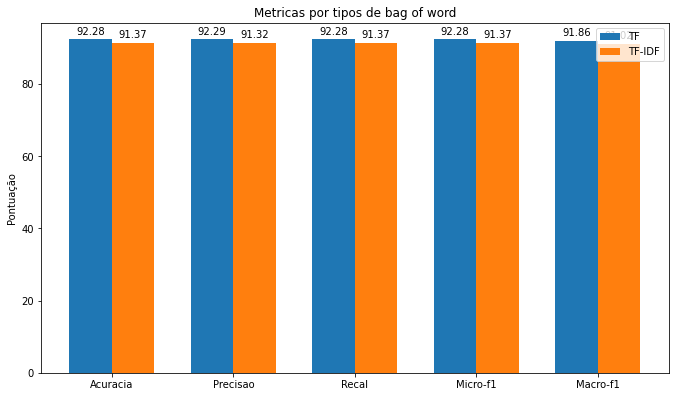

In [15]:
labels_numbers = np.arange(len(df_result.columns))  # the label locations
width_bar = 0.35  # the width of the bars

# Arredondar os valores das métricas para melhorar a visualização no plot.
tf_metrics_list = list(round(df_result.iloc[0] * 100, 2))
tf_idf_metrics_list = list(round(df_result.iloc[1] * 100, 2))


fig, ax = plt.subplots()
tf_group = ax.bar(labels_numbers - width_bar/2, tf_metrics_list, width_bar, label='TF')
tf_idf_group = ax.bar(labels_numbers + width_bar/2, tf_idf_metrics_list, width_bar, label='TF-IDF')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Pontuação')
ax.set_title('Metricas por tipos de bag of word')
ax.set_xticks(labels_numbers, list(df_result.columns))
ax.legend()
ax.bar_label(tf_group, padding=3)
ax.bar_label(tf_idf_group, padding=3)
fig.tight_layout()
fig.set_size_inches(10, 6)

plt.show()